In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-23_14-50_20200101_20200831.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.002489110143123833

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

NQ       0.25
YM       0.25
ES       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    13705.30
GC     6696.88
NQ    24091.60
YM     8353.60
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

52847.37999999999

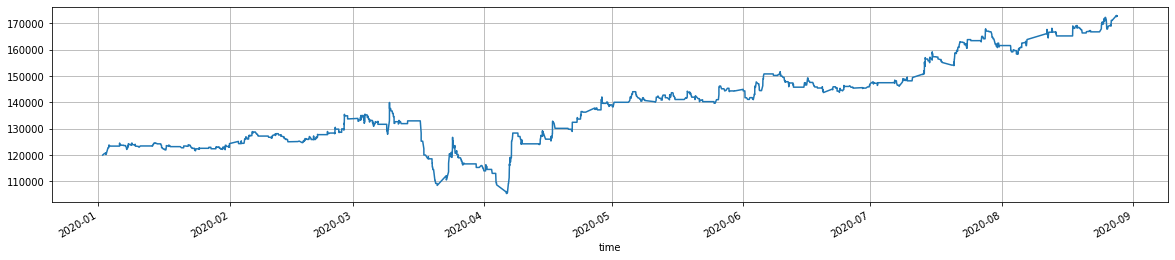

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    183
 GC    336
 NQ    904
 YM    184
 Name: action, dtype: int64,
 1607)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.063953
 GC    1.953488
 NQ    5.255814
 YM    1.069767
 Name: action, dtype: float64,
 9.343023255813954)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     384.30
GC     813.12
NQ    1898.40
YM     386.40
Name: commission, dtype: float64

In [16]:
df.commission.sum()

3482.2200000000007

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.42,53.30,747.49,-459.33,1.63,47.53,452.0
GC,0.39,39.86,969.01,-546.49,1.77,44.56,168.0
YM,0.49,90.80,1031.02,-809.41,1.27,92.40,92.0
ES,0.40,150.61,1730.87,-883.75,1.96,162.10,91.0
total,0.42,65.81,932.58,-564.22,1.65,64.44,803.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.087854,0.070917,0.566202,0.659398
GC,-0.087854,1.000000,-0.140257,0.038606,0.350977
NQ,0.070917,-0.140257,1.000000,0.068212,0.538226
YM,0.566202,0.038606,0.068212,1.000000,0.676063
total,0.659398,0.350977,0.538226,0.676063,1.000000


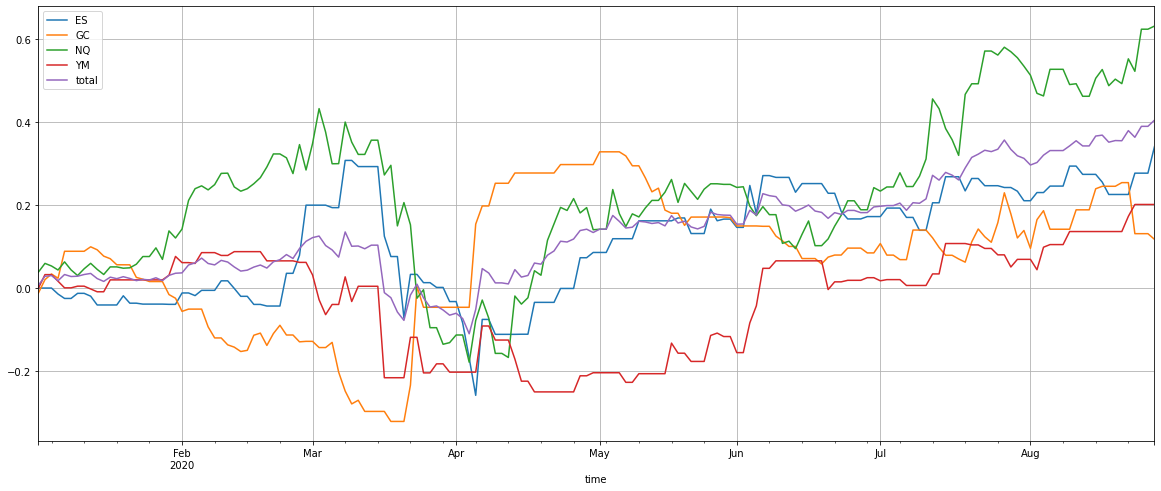

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

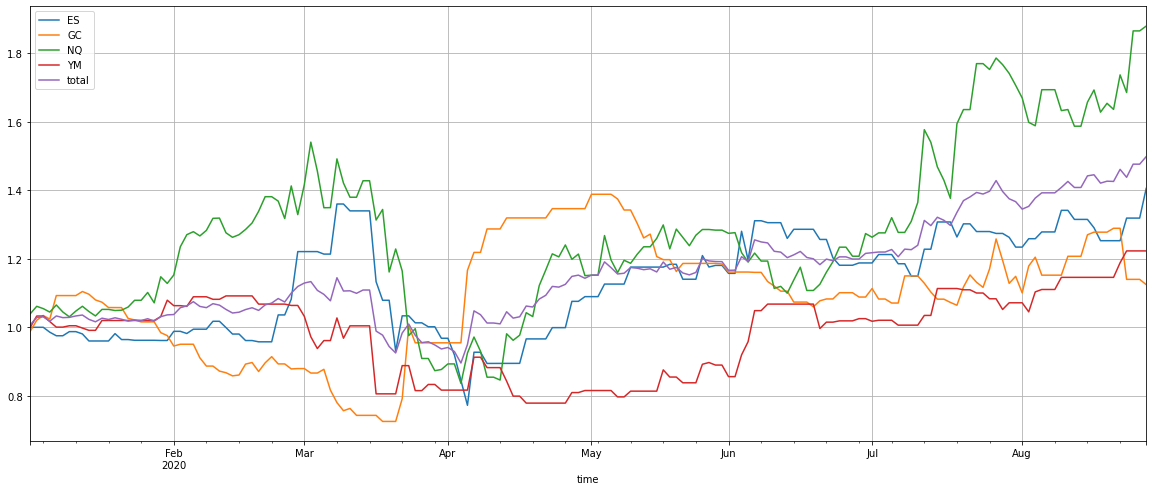

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.646157,0.187536,1.519328,0.342858,0.807767
Cumulative returns,0.405239,0.124474,0.878853,0.222885,0.497993
Annual volatility,0.591027,0.580022,0.714027,0.471096,0.325590
Sharpe ratio,1.132484,0.563869,1.647789,0.865994,1.981724
Calmar ratio,1.495841,0.546381,3.325045,1.196454,3.715748
Stability,0.524723,0.249420,0.363990,0.063556,0.769129
Max drawdown,-0.431969,-0.343233,-0.456935,-0.286562,-0.217390
Omega ratio,1.352496,1.162171,1.356399,1.275395,1.472566
Sortino ratio,1.925262,1.164356,2.666908,1.253904,3.313984
Skew,0.937127,3.526931,0.354140,-0.910275,0.329101


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-3.85,-2.43,12.81,7.91,3.63
2020-02-29,26.97,-9.86,17.79,-1.42,7.99
2020-03-31,-20.71,8.55,-34.01,-23.22,-16.29
2020-04-30,12.55,41.00,31.23,-0.14,22.02
2020-05-31,8.37,-11.99,11.54,9.11,4.24
2020-06-30,0.61,-8.14,-0.78,15.22,2.02
2020-07-31,3.89,5.55,33.96,4.51,12.41
2020-08-31,13.88,-2.11,10.13,14.13,9.62


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       41.0
GC       12.0
NQ       88.0
YM       22.0
total    50.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-04-07 08:54:00,ES,SELL,2686.25,5520.80
2020-03-09 14:30:00,ES,BUY,2790.50,5170.80
2020-04-17 01:04:30,ES,SELL,2881.75,4358.30
2020-03-24 11:51:30,GC,SELL,1681.90,3965.16
2020-04-28 11:50:30,ES,SELL,2900.00,3883.30
...,...,...,...,...
2020-04-06 00:00:00,ES,BUY,2504.50,-2579.20
2020-03-17 16:52:00,YM,BUY,20728.00,-2844.20
2020-03-17 02:04:30,YM,BUY,20967.00,-3084.20


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2020-04-07,0.200553,0.044677,0.050387,0.117553,0.103293
2020-03-23,0.110277,0.091344,-0.052140,0.102193,0.062919
2020-03-09,0.120413,-0.044495,0.105387,0.068720,0.062506
2020-04-06,-0.085973,0.221677,0.105800,0.000000,0.060376
2020-07-13,0.068470,-0.018495,0.155600,0.028193,0.058442
...,...,...,...,...,...
2020-03-25,-0.019723,-0.048828,0.020747,-0.082087,-0.032473
2020-03-10,0.000000,-0.030495,-0.047227,-0.057640,-0.033840
2020-03-19,0.000000,0.000000,-0.135753,0.000000,-0.033938
